<h1>Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto</h1>
<h2>Part 1: <i>scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M,</i></h2>
<ul>
    <li>Only process the cells that have an assigned borough. Ignore cells with a borough that is 'Not assigned'.</li>
    <li>If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough.</li>
    <li>Combined neighborhoods into one row separated with a comma grouped by postcode</li>
</ul>


In [119]:
import pandas as pd

In [120]:
#Get the first html table from the following wikipedia page

df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]


In [121]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

df=df[df.Borough != 'Not assigned']

In [122]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

df.loc[df.Neighbourhood.eq('Not assigned'), ['Neighbourhood']] = df.Borough


In [124]:
#More than one neighborhood can exist in one postal code area. 
#For example, in the table on the Wikipedia page, you will notice that 
#M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. 
#These two rows will be combined into one row with the neighborhoods separated with a comma...

df=pd.DataFrame(df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join))
df = df.reset_index()

df.head()


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [125]:
print(df.shape)

(103, 3)


<hr>
<h2>Part 2: <i>Add Latitude and Longitude to dataframe created in part 1</i></h2>
<p>The geocoder package was not working while I doing his assignment so the provided csv file was used to get the Latitude and Longitude </p>

In [126]:
dfgeodata = pd.read_csv("https://cocl.us/Geospatial_data")

In [127]:
neighborhoods=df.merge(dfgeodata[['Postal Code','Latitude','Longitude']], left_on='Postcode', right_on='Postal Code', how='left')
neighborhoods.drop(['Postal Code'], axis=1, inplace=True)

In [128]:
neighborhoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [129]:
neighborhoods.shape

(103, 5)

<hr>
<h2>Part 3: <i>Explore and cluster neighborhoods</i></h2>
<p><b>Instructions </b><i>Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.</i></p>

In [13]:
import numpy as np # library to handle data in a vectorized manner

#import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-3.3.0               |           py36_0         747 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

In [130]:
# The code was removed by Watson Studio for sharing.

<b>helper functions</b>

In [132]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [133]:
#get venue data from Foursquare 
#todo: update to work with most(more) recent version of the of the Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
       
    return(nearby_venues)
    

In [136]:
#function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

<p>We are only interested in Toronto so the neighborhoods dataframe is filtered to only include rows that have a bourough valuse that contains the string 'toronto'</p>
<p>Call the getNearbyVenues for each row in our new filtered dataframe and get the venues from Foursquare</p>

In [134]:
#Filter neighborhoods to only contain bourough with the string 'toronto'

toronto_data=neighborhoods[neighborhoods.Borough.str.contains('Toronto')]
toronto_data = toronto_data.reset_index()

#Call Foursquare and get venues for each neighborhood 
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


<p>Coffee Shop is the most common Venue Category and is not important to me so I am removing them</p>

In [250]:
toronto_venues = toronto_venues[toronto_venues['Venue Category']!='Coffee Shop']

In [243]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()


<p>Get the top 7 venue types for each neighgorhood and add them to a new dataframe, neighborhoods_venues_sorted</p>

In [244]:


num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Adelaide, King, Richmond",Café,Hotel,Theater,American Restaurant,Sushi Restaurant,Concert Hall,Restaurant
1,Berczy Park,Café,Hotel,Restaurant,Beer Bar,Japanese Restaurant,Italian Restaurant,Farmers Market
2,"Brockton, Exhibition Place, Parkdale Village",Café,Restaurant,Bar,Bakery,Furniture / Home Store,Tibetan Restaurant,Hotel
3,Business Reply Mail Processing Centre 969 Eastern,Park,Brewery,Pizza Place,Italian Restaurant,Sushi Restaurant,Pub,Snack Place
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Harbor / Marina,Garden,Café,Scenic Lookout,Airport,Airport Lounge,Dog Run


<h2>K-Means Clustering!</h2>
<p>Group neighborhoods into 5 clusters

In [245]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')




In [246]:
#get the center of the map 
address = 'Toronto Canada'
geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [252]:
# create map, don't forget to spell neighborhood as neighbouhood

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='#555555', #rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

folium.Map

<h2>Just in case</h2>
<p>The map was not displaying on the shared github link, here is a static image of the map as it appears in IBM Watson Studio</p>

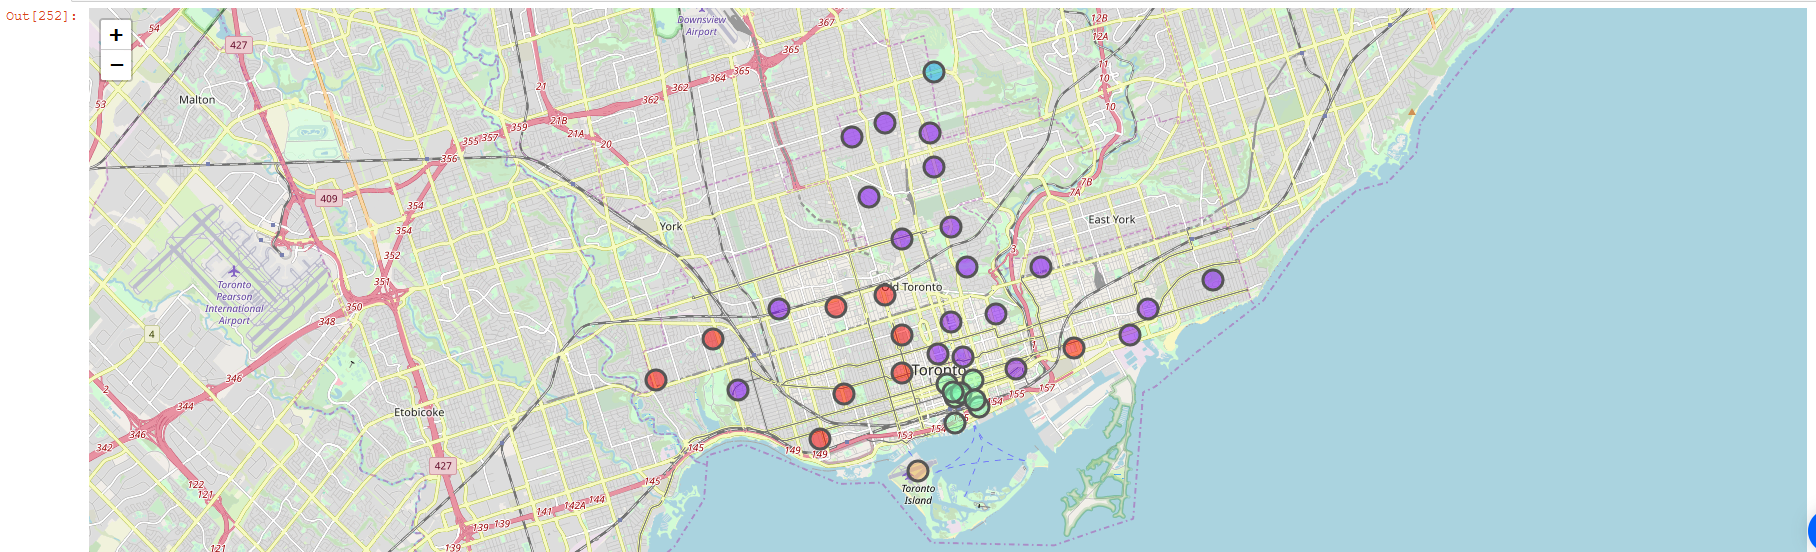

Lets take a look at the top 5 Venue Categories by Cluster to see what makes each cluster distinct.
<ul><li>Cluster 0 has a large number or Bars compared to the other clusters</li>
<li>Cluster 1 has the most Italian resturants but what makes it differnt is the high number of parks (nice).</li>
<li>Cluster 3 looks like a tourist area with a large number of hotels.</li>
    </ul>


In [251]:
ttt = toronto_venues[['Neighborhood','Venue Category']]
tttn = neighborhoods_venues_sorted[['Cluster Labels','Neighborhood']]
ttt = ttt.join(tttn.set_index('Neighborhood'), on='Neighborhood')
ttt['c']=1
tttg = ttt.groupby(['Cluster Labels','Venue Category']).agg({'c': ['sum']})
tttg.columns = ['Cat_Count']
tttg = tttg.reset_index()
tttgs = tttg.sort_values(['Cluster Labels','Cat_Count'], ascending=[True, False])
pd.concat([tttgs[tttgs['Cluster Labels']==0].head(),tttgs[tttgs['Cluster Labels']==1].head(),tttgs[tttgs['Cluster Labels']==2].head(),tttgs[tttgs['Cluster Labels']==3].head(),tttgs[tttgs['Cluster Labels']==4].head()])


,Cluster Labels,Venue Category,Cat_Count
28,0,Café,67
12,0,Bar,40
10,0,Bakery,34
152,0,Restaurant,25
103,0,Italian Restaurant,23
301,1,Italian Restaurant,51
223,1,Café,49
329,1,Park,47
365,1,Sushi Restaurant,41
336,1,Pizza Place,34
